In [1]:
import os
import sys
import csv
import ast
import umap
import torch
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt

from copy import deepcopy
from collections import Counter
from sklearn.decomposition import PCA
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import NullFormatter
from statannotations.Annotator import Annotator

sys.path.insert(0, '/home/darryl/dev/LTFF/toy_model_interpretability')
from model_helper import *
from train_model import sample_vectors_equal, make_random_embedder

2024-02-01 16:01:03.859892: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-01 16:01:03.957059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [2]:
model = 'model3'
# model='soft_dot_penalised_model
k = 1024 # size of nonlinear layer
log2_batch_size = 13
log2_training_steps = 18
sample_kind = 'equal'
init_bias = 0.0
nonlinearity = 'ReLU'
task = 'autoencoder'
decay = 0.0
eps = 0.015625
m = 64 # input dimensions
N = 512 # number of features
reg = 0.0
# lr = 0.001
lrs = [0.001,0.003,0.005,0.007,0.01,0.03]

In [3]:
print(lrs)

# Load and process data
names = list([
    f"../my_models/{model}_{task}_{nonlinearity}_k_{k}_batch_{log2_batch_size}_steps_{log2_training_steps}_learning_rate_{lr}_sample_{sample_kind}_init_bias_{init_bias}_decay_{decay}_eps_{eps}_m_{m}_N_{N}_reg_{reg}.pt"
    for lr in lrs
])
ReLU_equal_lr_sweep = []
for n in names:
    try:
        ReLU_equal_lr_sweep.append(torch.load(n, map_location=torch.device('cpu')))
    except FileNotFoundError:
        print(n,'not found')

[0.001, 0.003, 0.005, 0.007, 0.01, 0.03]


In [4]:
batch = ReLU_equal_lr_sweep[0] # lr = 0.001
fixed_embedder = batch['setup']['fixed_embedder']

(-0.5, 511.5, 63.5, -0.5)

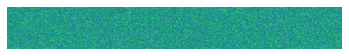

In [5]:
plt.imshow(fixed_embedder)
plt.axis('off')

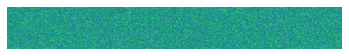

In [6]:
plt.imshow(fixed_embedder)
plt.axis('off')
plt.show()

In [7]:
fixed_embedder.shape

torch.Size([64, 512])

In [8]:
vs, ins = sample_vectors_equal(N, eps, 2**log2_batch_size, torch.tensor(fixed_embedder, requires_grad=False, device='cuda', dtype=torch.float))

/tmp/ipykernel_243866/332273646.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vs, ins = sample_vectors_equal(N, eps, 2**log2_batch_size, torch.tensor(fixed_embedder, requires_grad=False, device='cuda', dtype=torch.float))


In [9]:
vs.shape

torch.Size([8192, 512])

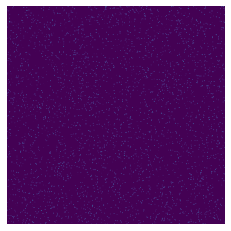

In [10]:
plt.imshow(vs.cpu().numpy()[:512,:])
plt.axis('off')
plt.show()

In [11]:
vs, _ = sample_vectors_equal(N, eps, 10000, torch.tensor(fixed_embedder, requires_grad=False, device='cuda', dtype=torch.float))
vs = vs.cpu().numpy()
vs[:,100] = np.linspace(0,1,10000)

/tmp/ipykernel_243866/4221924264.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vs, _ = sample_vectors_equal(N, eps, 10000, torch.tensor(fixed_embedder, requires_grad=False, device='cuda', dtype=torch.float))


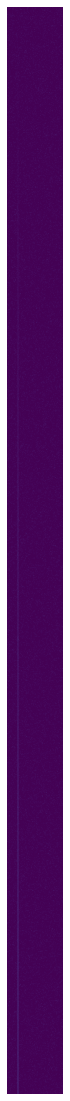

In [12]:
plt.figure(figsize=(10,20))
plt.imshow(vs)
plt.axis('off')
plt.show()

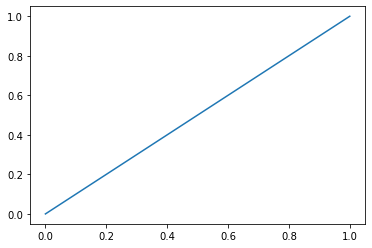

In [13]:
plt.plot(np.linspace(0,1,10000), vs[:,100])
plt.show()

In [14]:
ins = np.dot(vs, fixed_embedder.T)

In [15]:
ins.shape

(10000, 64)

In [16]:
plt.figure(figsize=(20,20))
plt.imshow(ins)
plt.axis('off')
plt.show()

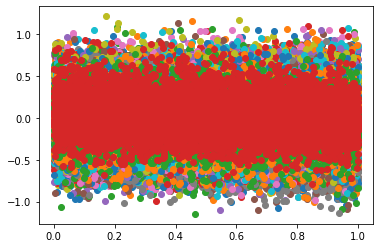

In [17]:
for i in range(ins.shape[-1]):
    plt.scatter(np.linspace(0,1,10000), ins[:,i])
plt.show()

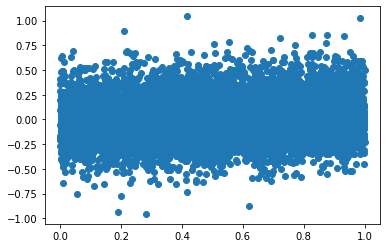

In [18]:
plt.scatter(np.linspace(0,1,10000), ins[:,2])
plt.show()

0 [0.25689344 0.00283304]


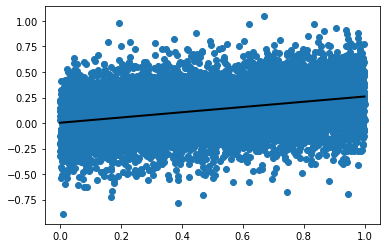

1 [0.09556265 0.03475353]


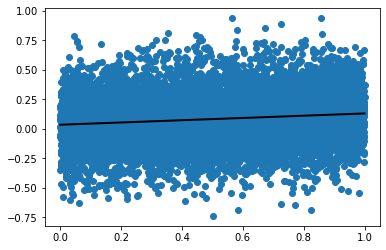

2 [ 0.07607945 -0.01011765]


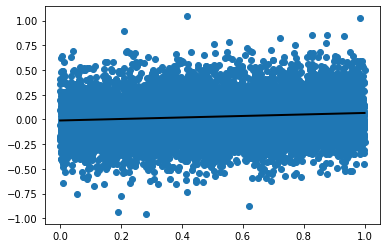

3 [-0.00601947  0.02397201]


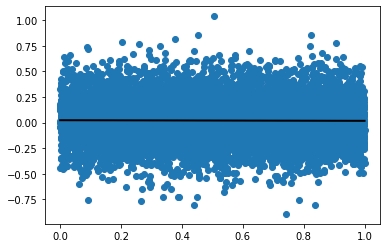

4 [ 0.09893825 -0.00485231]


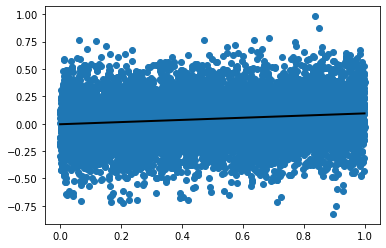

5 [-0.14209834 -0.05883832]


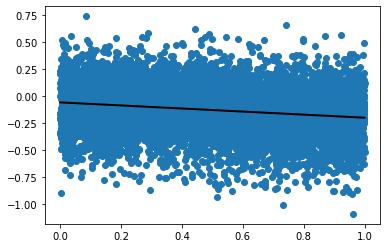

6 [ 0.04702336 -0.01165218]


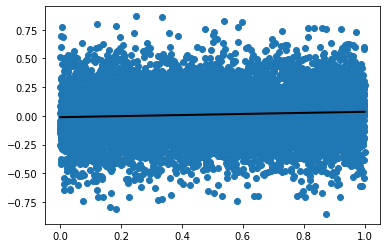

7 [0.08154593 0.01769962]


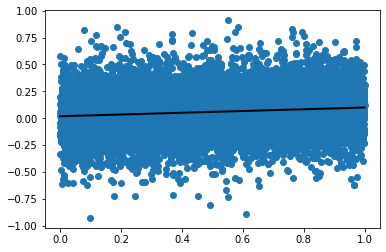

8 [ 0.01434872 -0.01548286]


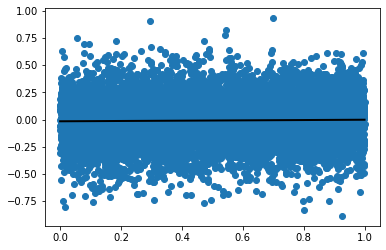

9 [0.08033797 0.03019778]


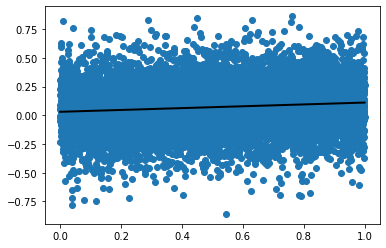

10 [-0.11901524 -0.01931719]


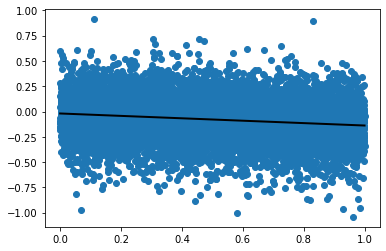

11 [0.10985072 0.01777264]


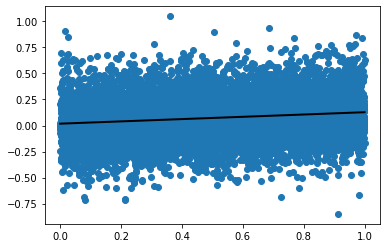

12 [-0.16870306  0.01735082]


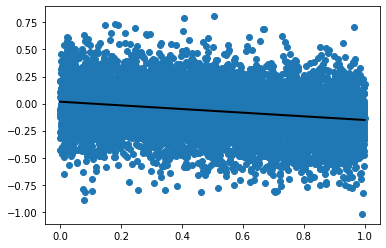

13 [0.02612689 0.00424699]


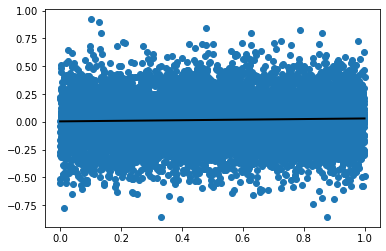

14 [-0.12032495 -0.02471362]


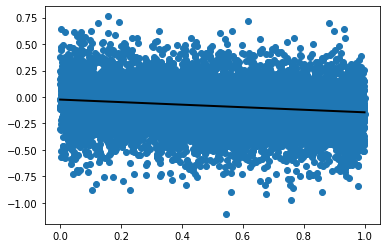

15 [0.01807132 0.0056402 ]


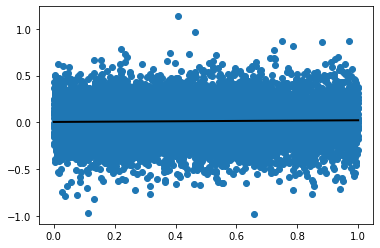

16 [0.23024777 0.03044229]


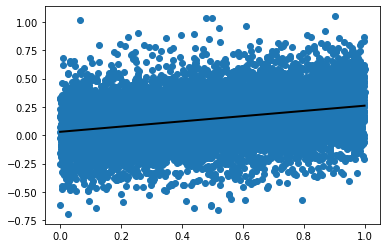

17 [-0.04886155  0.01092494]


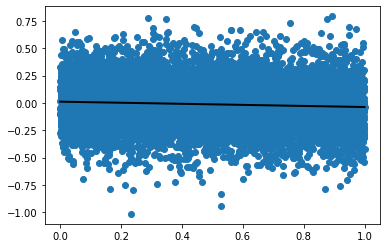

18 [ 0.24194389 -0.00033195]


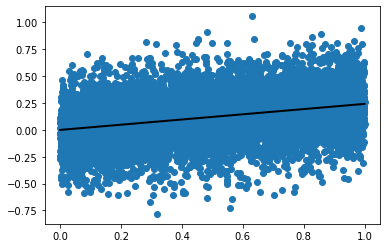

19 [-0.03131775 -0.01969997]


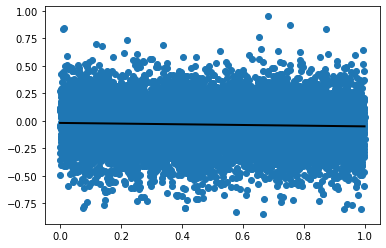

20 [ 0.13013654 -0.01206602]


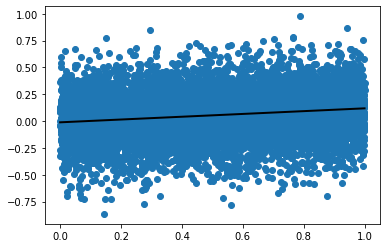

21 [ 0.12499551 -0.00470871]


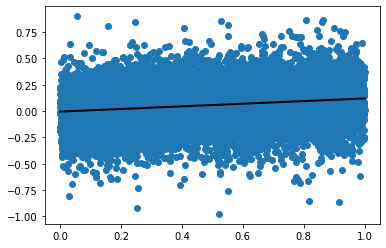

22 [-0.09331148 -0.0176829 ]


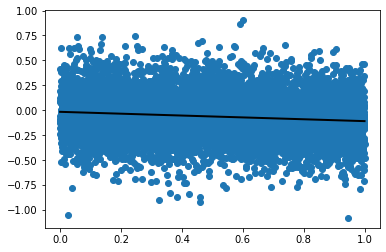

23 [-0.1591133   0.02108958]


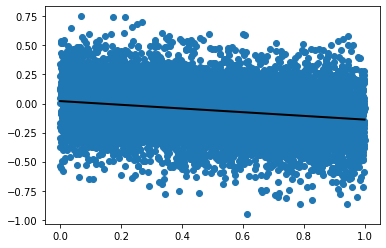

24 [0.02028282 0.01082929]


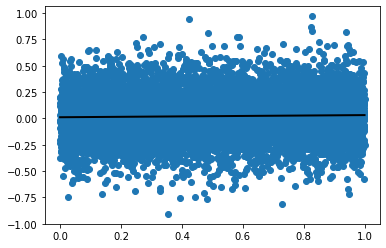

25 [0.13538171 0.01210618]


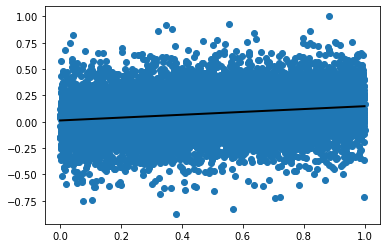

26 [0.00150187 0.03595984]


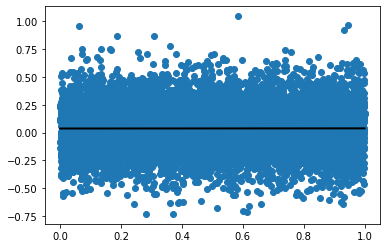

27 [-0.47606983  0.03167504]


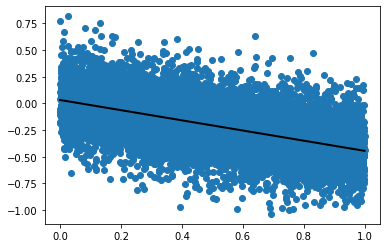

28 [-0.06198604  0.02892062]


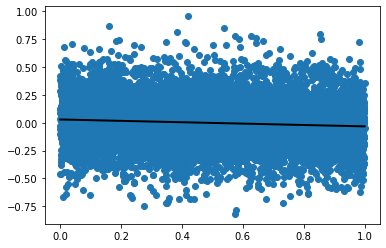

29 [-0.1723236   0.02757993]


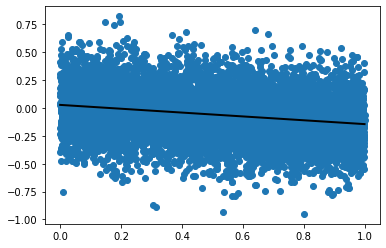

30 [-0.1291726  -0.01847324]


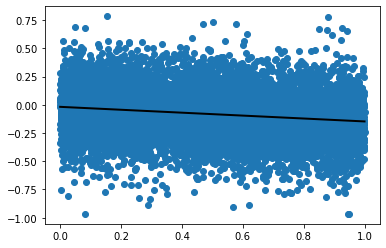

31 [-0.10603527 -0.01467707]


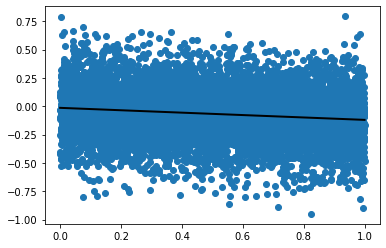

32 [-0.01590614 -0.02208687]


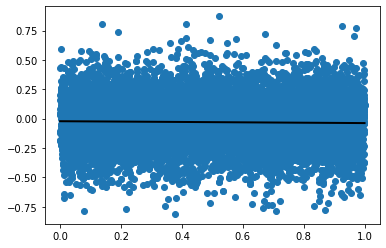

33 [-0.06832023 -0.00126554]


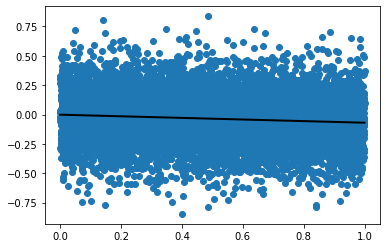

34 [ 0.23482879 -0.00490416]


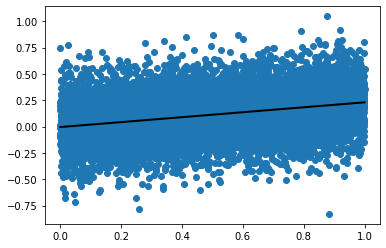

35 [-0.16214362 -0.04183922]


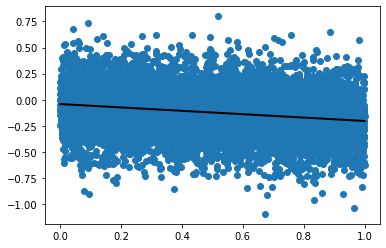

36 [0.062764   0.02143429]


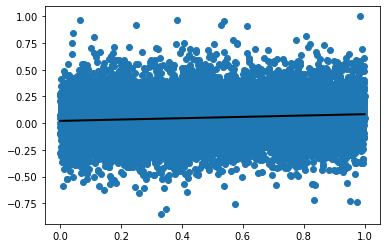

37 [-0.0873083  -0.02243726]


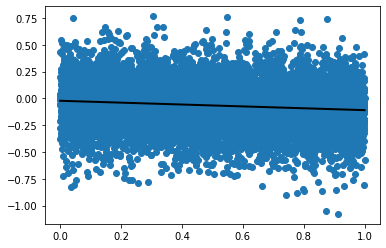

38 [0.11184517 0.00472594]


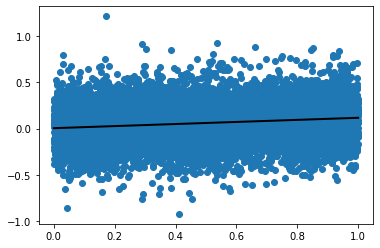

39 [0.15037354 0.03227586]


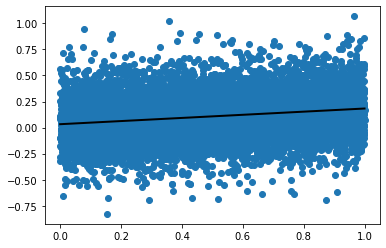

40 [-0.22449858  0.00695155]


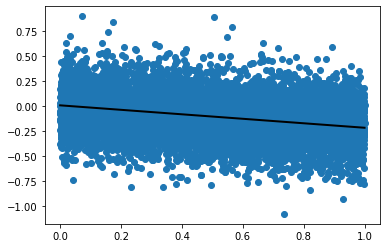

41 [ 0.11635131 -0.00424562]


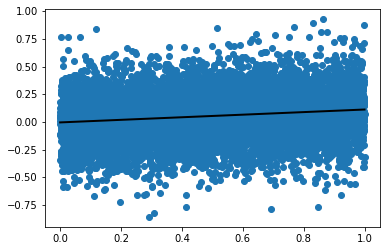

42 [-0.10150133  0.03445671]


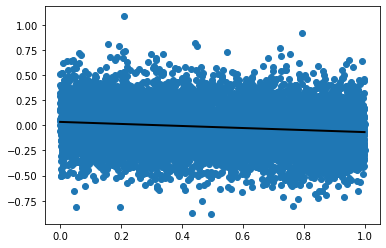

43 [ 0.03659843 -0.02822705]


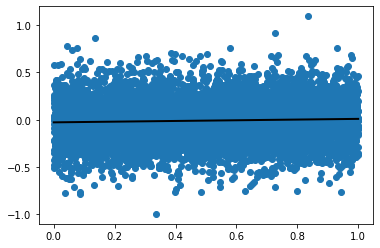

44 [0.01494139 0.0001946 ]


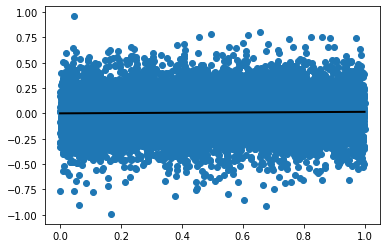

45 [0.02894172 0.00838853]


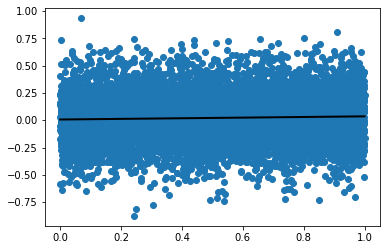

46 [ 0.01327757 -0.01363259]


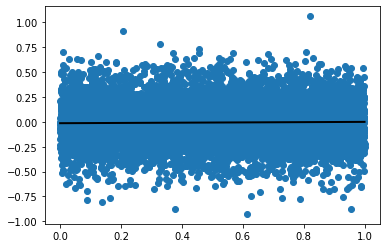

47 [-0.08309151 -0.00238506]


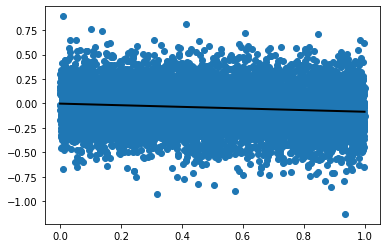

48 [0.01695474 0.00758023]


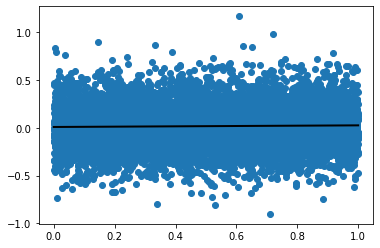

49 [0.03879046 0.02820932]


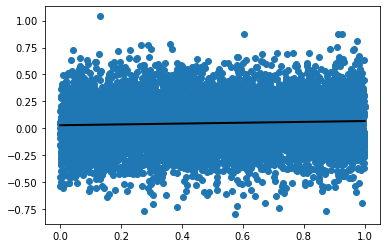

50 [-0.07926903  0.020147  ]


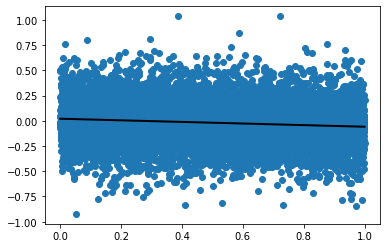

51 [0.0091485  0.03701576]


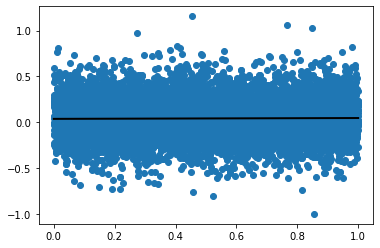

52 [-0.17141313  0.01199236]


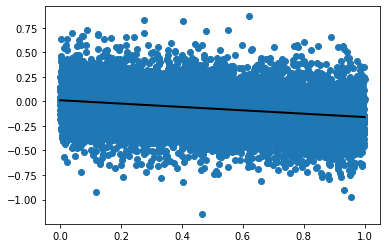

53 [0.07962542 0.00537962]


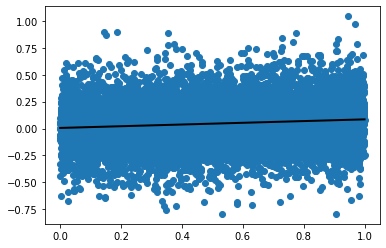

54 [ 0.07184468 -0.00076355]


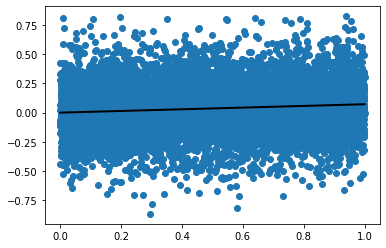

55 [-0.08316242  0.01846253]


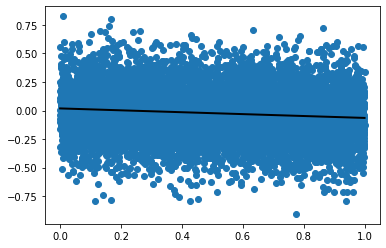

56 [ 0.0342639  -0.01448302]


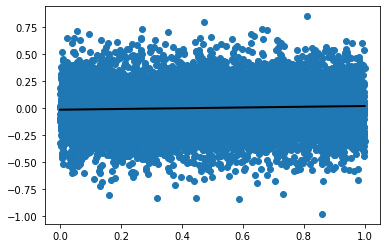

57 [-0.06238805  0.0033769 ]


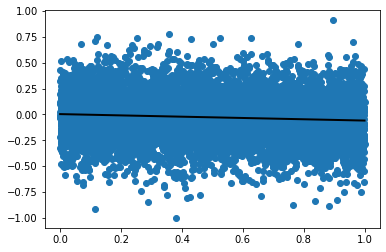

58 [0.03806968 0.04339238]


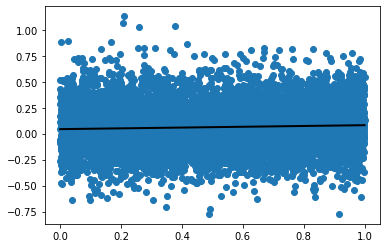

59 [0.04216352 0.00222711]


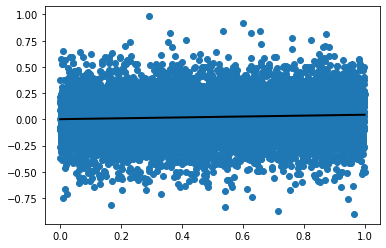

60 [0.00756626 0.01427965]


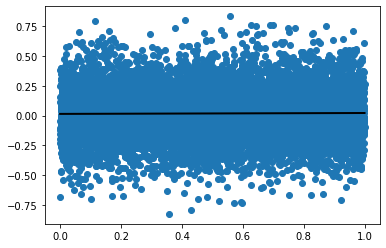

61 [-7.38451450e-02 -4.90409553e-05]


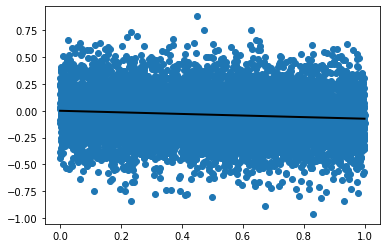

62 [-0.11408994  0.03691135]


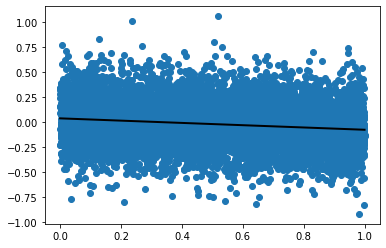

63 [-0.09350631  0.0703192 ]


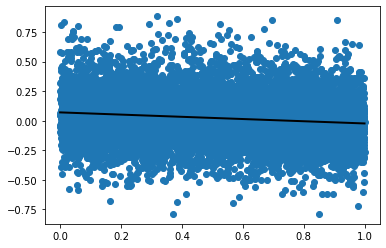

In [19]:
d = {'zero_amps':[], 'one_amps':[], 'grads':[], 'intercepts':[]}
for i in range(ins.shape[-1]):
    plt.scatter(np.linspace(0,1,10000), ins[:,i])
    coef = np.polyfit(np.linspace(0,1,10000), ins[:,i],1)
    print(i, coef)
    d['zero_amps'].append(np.abs(ins[0,i]))
    d['one_amps'].append(np.abs(ins[-1,i]))
    d['grads'].append(coef[0])
    d['intercepts'].append(coef[1])
    poly1d_fn = np.poly1d(coef)
    plt.plot(np.linspace(0,1,10000), poly1d_fn(np.linspace(0,1,10000)), 'k-', lw=2)
    plt.show()

In [20]:
# d['random_uniform'] = [np.mean(make_random_embedder(100,10).cpu().numpy()) for i in range(64)]

    zero_amps  one_amps
0    0.273683  0.187496
1    0.074215  0.369168
2    0.162312  0.224676
3    0.012499  0.391305
4    0.003247  0.377505
..        ...       ...
59   0.086953  0.502595
60   0.680448  0.265126
61   0.110759  0.039399
62   0.342824  0.131540
63   0.068289  0.268769

[64 rows x 2 columns]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

zero_amps vs. one_amps: Mann-Whitney-Wilcoxon test two-sided, P_val:1.291e-01 U_stat=1.729e+03


(<AxesSubplot:>, [<statannotations.Annotation.Annotation at 0x7f210867fe80>])

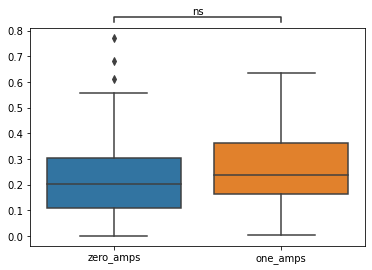

In [21]:
df = pd.DataFrame(data=d, columns=['zero_amps', 'one_amps'])
print(df)
ax = sns.boxplot(data=df)

annotator = Annotator(ax, pairs=[('zero_amps', 'one_amps')], data=df)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

       grads  intercepts
0   0.256893    0.002833
1   0.095563    0.034754
2   0.076079   -0.010118
3  -0.006019    0.023972
4   0.098938   -0.004852
..       ...         ...
59  0.042164    0.002227
60  0.007566    0.014280
61 -0.073845   -0.000049
62 -0.114090    0.036911
63 -0.093506    0.070319

[64 rows x 2 columns]


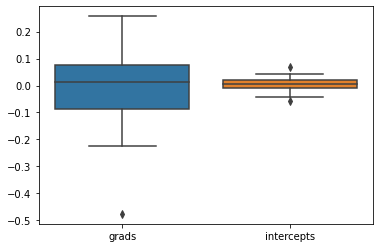

In [22]:
df = pd.DataFrame(data=d, columns=['grads', 'intercepts'])
print(df)
ax = sns.boxplot(data=df)

# How unique is the unit amplitude signature.

In [23]:
try:
    del vs
except NameError:
    pass

for i in range(m):
    try:
        v, _ = sample_vectors_equal(N, eps, 1000, torch.tensor(fixed_embedder, requires_grad=False, device='cuda', dtype=torch.float))
        v = v.cpu().numpy()
        v[:,i] = 1.0
        vs = np.concatenate((vs, v))
    except NameError:
        vs = v

/tmp/ipykernel_243866/1955738485.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v, _ = sample_vectors_equal(N, eps, 1000, torch.tensor(fixed_embedder, requires_grad=False, device='cuda', dtype=torch.float))


In [24]:
vs_control, ins = sample_vectors_equal(N, eps, 64000, torch.tensor(fixed_embedder, requires_grad=False, device='cuda', dtype=torch.float))

/tmp/ipykernel_243866/1776540111.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vs_control, ins = sample_vectors_equal(N, eps, 64000, torch.tensor(fixed_embedder, requires_grad=False, device='cuda', dtype=torch.float))


In [25]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(np.concatenate((vs, vs_control.cpu().numpy())))

In [26]:
embedding.shape

(128000, 2)

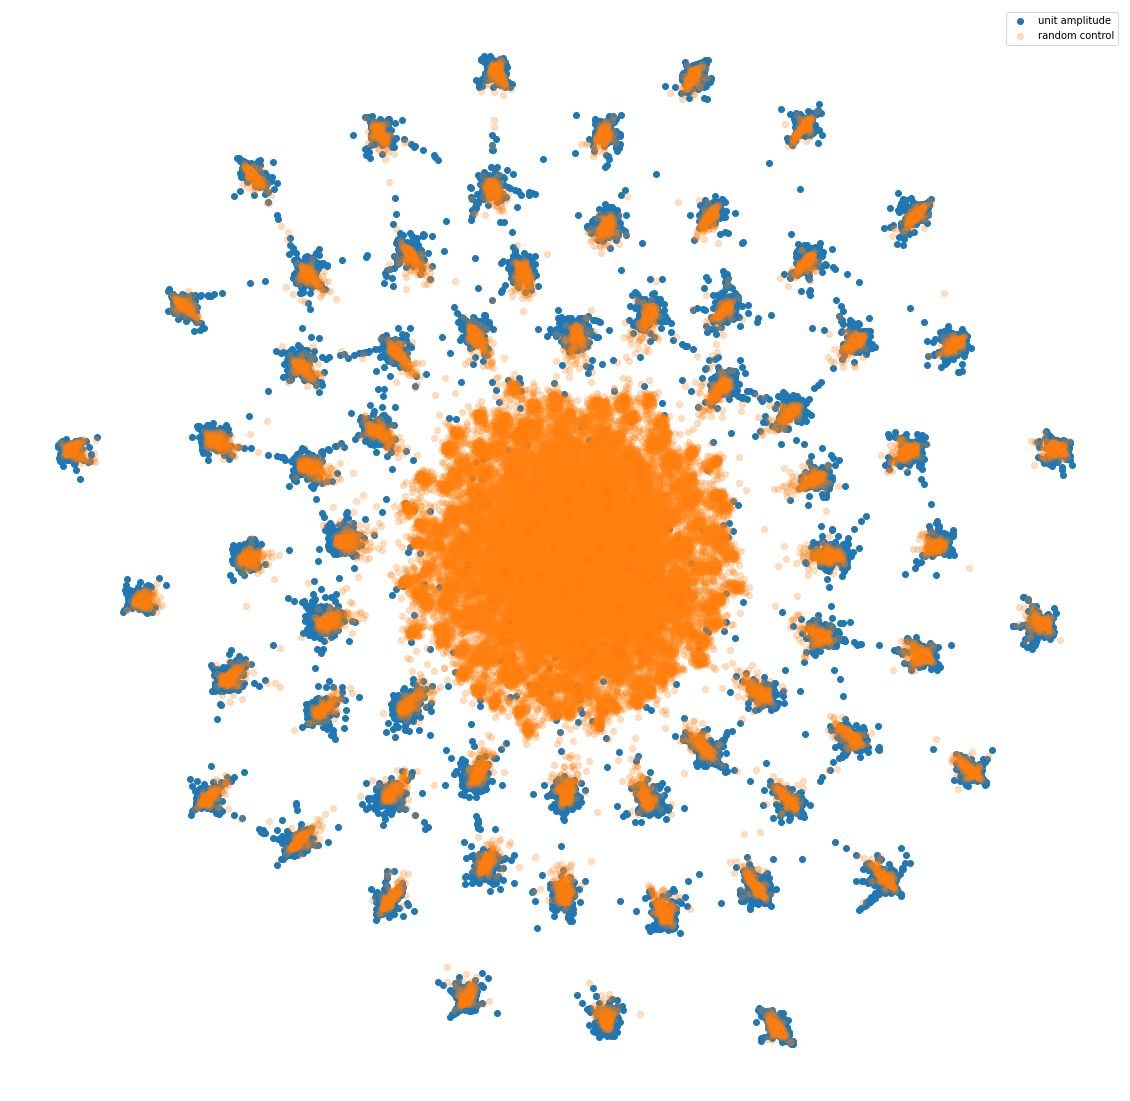

In [27]:
plt.figure(figsize=(20,20))
plt.scatter(embedding[:64000,0], embedding[:64000,1], label='unit amplitude')
plt.scatter(embedding[64000:,0], embedding[64000:,1], label='random control', alpha=0.25)
plt.axis('off')
plt.legend()
plt.show()

In [28]:
pca = PCA(n_components=2)
embedding = pca.fit_transform(vs)

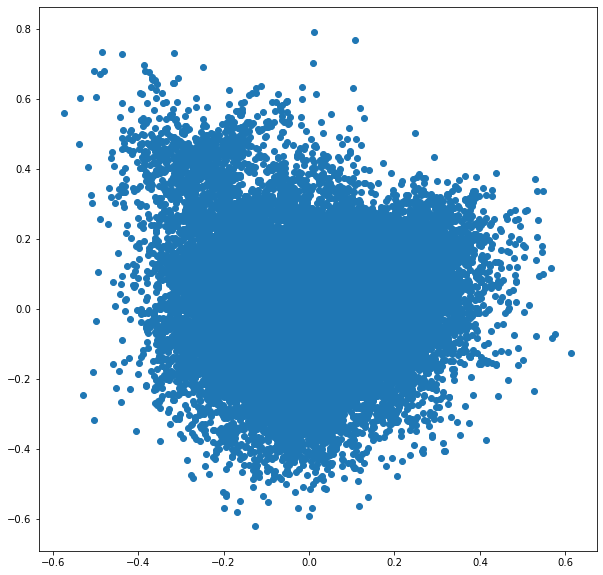

In [29]:
plt.figure(figsize=(10,10))
plt.scatter(embedding[:,0], embedding[:,1])

# Proof model can be more certain a feature is present when it has unit amplitude

Assume 16 bit float for convenience.

For a given training example, the probability a feature is active is $1/64$.

The probability that an active feature will have unit amplitude for a single training example is $(1/64)(1/2^{16})=(1/2^{6})(1/2^{16})=(1/2^{22})$.

The probability that two active features will have unit amplitude for a single training example is $(1/64)(1/2^{16})(1/64)(1/2^{16})=(1/2^{6})(1/2^{16})(1/65)(1/2^{16})\sim(1/2^{44})$.

The number of training examples the model was trained on is $(2^{18})(2^{13})=(2^{31})$.

Therefore, during training no two features will simultaneously have unit amplitude for a single training example. More generally no two features will be the same value for a single training example.

In [30]:
1/64 * 1/(2**16)

2.384185791015625e-07

In [31]:
1/(2**22)

2.384185791015625e-07

In [32]:
1/(2**44)

5.684341886080802e-14

In [33]:
(1/65)*(1/2**(38))

5.5968904724487895e-14

A training example is a vector of dimension (512,1).

The probability that any training example will be any particular vector is the probability of ordered sampling with replacement any of $2^{16}$ single values for 512 trials i.e. $(1/2^{16})^{512}=(1/2^{528})$. 

*Therefore, given $2^{31}$ training examples during training the same training example will not occur twice.*



The fixed random embedder is a matrix of dimension (512,64).

The probability that any column will be any particular vector is $(1/2^{16})^{512}=(1/2^{528})$. 

*Therefore, given $2^{6}$ trials no two columns will be the same.*

**What is the probability that two embedded features will be the same value?**

The probability of an embedded feature having a particular value given a single training example is the probability of the fixed embedder column vector corresponding to that feature and any single training example i.e. $(1/2^{528})(1/2^{528})=(1/2^{1056})$.

Across the entire training set there are $2^{31}$ trials.

The probability of observing any particular value for an embedded feature during training is the $(2^{31})(1/2^{1056})=(1/2^{1025})$

*Therefore, during training every embedded feature signature is unique to the input feature signature.*

# Empirical calculation check

For 8-bit integer with 4 input features embedded to 2 features and for $2^{6}$ trials the probability of observing any particular value for an embedded feature during training is the $(2^{6})(1/2^{8})((4\times2)/2^{8})=(2^{6})
(1/2^{8})(2^{3}/2^{8})= (2^{6})(1/2^{8})(1/2^{5}) = (2^{6})(1/2^{13})=1/2^{7}$.

$(4/2^{8})$

In [34]:
r = []
fixed_embedder = np.random.randint(low=-2**7, high=2**7, size=[2, 4], dtype=np.int8)
print(fixed_embedder)
for _ in range(1000):
    x = np.random.randint(2**8, size=[2**8, 4], dtype=np.uint8)
    r.append((2**8 - len(set(np.dot(x, fixed_embedder.T).ravel())))/2**8)

[[  98  -13    4   71]
 [ -18  112   36 -118]]


In [35]:
r

[-0.984375,
 -0.98046875,
 -0.984375,
 -0.98046875,
 -0.97265625,
 -0.984375,
 -0.98828125,
 -0.9921875,
 -0.98046875,
 -0.98046875,
 -0.98828125,
 -0.97265625,
 -0.9921875,
 -0.9765625,
 -0.984375,
 -0.98828125,
 -0.98828125,
 -0.98828125,
 -0.98046875,
 -0.98828125,
 -0.99609375,
 -0.9765625,
 -0.99609375,
 -0.9921875,
 -0.9921875,
 -0.984375,
 -0.99609375,
 -0.9765625,
 -0.99609375,
 -0.9921875,
 -0.98046875,
 -0.98046875,
 -0.97265625,
 -0.984375,
 -1.0,
 -0.984375,
 -0.9921875,
 -0.98828125,
 -0.97265625,
 -0.9921875,
 -0.9765625,
 -0.98046875,
 -0.98828125,
 -0.9765625,
 -0.99609375,
 -0.9921875,
 -0.99609375,
 -0.984375,
 -0.96484375,
 -0.99609375,
 -0.9921875,
 -0.98046875,
 -0.99609375,
 -0.98046875,
 -0.9765625,
 -0.984375,
 -0.9921875,
 -0.9921875,
 -0.9921875,
 -1.0,
 -0.99609375,
 -0.98828125,
 -0.98046875,
 -0.984375,
 -0.98828125,
 -0.9921875,
 -0.9921875,
 -0.98828125,
 -0.99609375,
 -0.9765625,
 -0.98046875,
 -0.99609375,
 -0.984375,
 -0.99609375,
 -0.98828125,
 -0.984

In [36]:
np.mean(r)

-0.987296875

---

In [37]:
(1/2**8)**2

1.52587890625e-05

In [38]:
x = np.random.randint(2**8, size=2, dtype=np.uint8)
print(len(set(x)))

2


In [39]:
2**16

65536

In [40]:
t = []
for _ in range(10000):
    r = []
    for _ in range((2**8)+1):
        r.append(2-len(set(np.random.randint(2**8, size=2, dtype=np.uint8))))
    t.append(np.sum(r))

In [41]:
np.mean(t)

1.022

In [42]:
x = np.random.rand(64)
print(x)
print(type(x))
print(type(x[0]))

[0.42459943 0.42969774 0.14540761 0.74904671 0.3053278  0.52383747
 0.053004   0.05747006 0.05403801 0.81985046 0.4192721  0.59411126
 0.6321047  0.56868884 0.54734303 0.18507971 0.08804124 0.86072609
 0.82963249 0.03592182 0.23599453 0.17326343 0.65518403 0.90385949
 0.35911232 0.71761582 0.25082334 0.48135934 0.57438887 0.89176414
 0.80785952 0.3727664  0.8639629  0.12908204 0.06430925 0.85664043
 0.30888916 0.88056089 0.2576285  0.73006533 0.09436496 0.232615
 0.52726223 0.04308832 0.7617998  0.31183035 0.75979397 0.93142594
 0.994626   0.36051258 0.01926523 0.45919762 0.79415938 0.9455705
 0.63415648 0.4629176  0.77877527 0.97980304 0.98062299 0.70516003
 0.19472776 0.54617149 0.92370746 0.86458354]
<class 'numpy.ndarray'>
<class 'numpy.float64'>


In [43]:
# t = []
# for _ in range(100):
#     r = []
#     for _ in range((2**8)+1):
#         r.append(2-len(set(np.random.rand(size=64))))
#     t.append(np.sum(r))

---

In [44]:
vs.shape

(64000, 512)

In [45]:
fixed_embedder = batch['setup']['fixed_embedder']

In [46]:
data = {}
for n in range(N):
    vs, _ = sample_vectors_equal(N, eps, 10000, torch.tensor(fixed_embedder, requires_grad=False, device='cuda', dtype=torch.float))
    vs = vs.cpu().numpy()
    vs[:,n] = np.linspace(0,1,10000)
    ins = np.dot(vs, fixed_embedder.T)
    d = {'zero_amps':[], 'one_amps':[], 'grads':[], 'intercepts':[]}
    for i in range(m):
#         plt.scatter(np.linspace(0,1,10000), ins[:,i])
        coef = np.polyfit(np.linspace(0,1,10000), ins[:,i],1)
#         print(n, i, coef)
        d['zero_amps'].append(np.abs(ins[0,i]))
        d['one_amps'].append(np.abs(ins[-1,i]))
        d['grads'].append(coef[0])
        d['intercepts'].append(coef[1])
        poly1d_fn = np.poly1d(coef)
#         plt.plot(np.linspace(0,1,10000), poly1d_fn(np.linspace(0,1,10000)), 'k-', lw=2)
#         plt.show()
    data[n] = d
#     df = pd.DataFrame(data=d, columns=['zero_amps', 'one_amps'])
# #     print(df)
#     ax = sns.boxplot(data=df)
    
#     annotator = Annotator(ax, pairs=[('zero_amps', 'one_amps')], data=df)
#     annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
#     annotator.apply_and_annotate()
#     plt.show()

/tmp/ipykernel_243866/1974951792.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vs, _ = sample_vectors_equal(N, eps, 10000, torch.tensor(fixed_embedder, requires_grad=False, device='cuda', dtype=torch.float))


In [47]:
print(data)

{0: {'zero_amps': [0.0034867525, 0.49101317, 0.16326268, 0.16553082, 0.06772118, 0.08828716, 0.2267611, 0.106217705, 0.11495559, 0.24250782, 0.2328808, 0.01538606, 0.007507786, 0.043962955, 0.107023135, 0.097607635, 0.015264913, 0.095617905, 0.34313753, 0.25369987, 0.050626144, 0.041563116, 0.29613668, 0.20607609, 0.26727352, 0.10230569, 0.33426923, 0.08305943, 0.13544767, 0.17531206, 0.23656073, 0.2296376, 0.28137338, 0.23518386, 0.28428268, 0.104999825, 0.19623253, 0.34900826, 0.14461946, 0.14456621, 0.050504252, 0.085321985, 0.010916375, 0.056133233, 0.28618062, 0.0653325, 0.29877713, 0.10365082, 0.4659474, 0.011341944, 0.037316702, 0.0042734854, 0.40703687, 0.076295644, 0.36551613, 0.28148574, 0.034197755, 0.25440726, 0.42844948, 0.106441766, 0.06655009, 0.051486656, 0.23006725, 0.22748516], 'one_amps': [0.17634581, 0.037208855, 0.27209702, 0.20677449, 0.0081199445, 0.09024452, 0.087273896, 0.15651587, 0.24086452, 0.22090171, 0.12665145, 0.12090957, 0.095035434, 0.0051865224, 0.142

In [48]:
try:
    del x
    del zero_amps
    del one_amps
except NameError:
    pass
for k in data.keys():
    try:
        x = np.concatenate((x, np.array(data[k]['grads'])[np.newaxis]))
        zero_amps = np.concatenate((zero_amps, np.array(data[k]['zero_amps'])[np.newaxis]))
        one_amps = np.concatenate((one_amps, np.array(data[k]['one_amps'])[np.newaxis]))
    except NameError:
        x = np.array(data[k]['grads'])[np.newaxis]
        zero_amps = np.array(data[k]['zero_amps'])[np.newaxis]
        one_amps = np.array(data[k]['one_amps'])[np.newaxis]

In [49]:
x.shape

(512, 64)

In [50]:
pca = PCA(n_components=2)
embedding = pca.fit_transform(x)

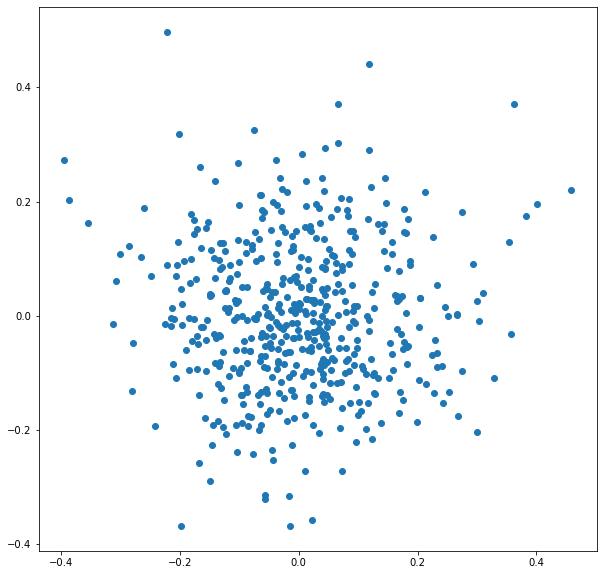

In [51]:
plt.figure(figsize=(10,10))
plt.scatter(embedding[:,0], embedding[:,1])

In [52]:
reducer = umap.UMAP()
# embedding = reducer.fit_transform(x)
embedding_ones = reducer.fit_transform(one_amps)
embedding_zeros = reducer.transform(zero_amps)

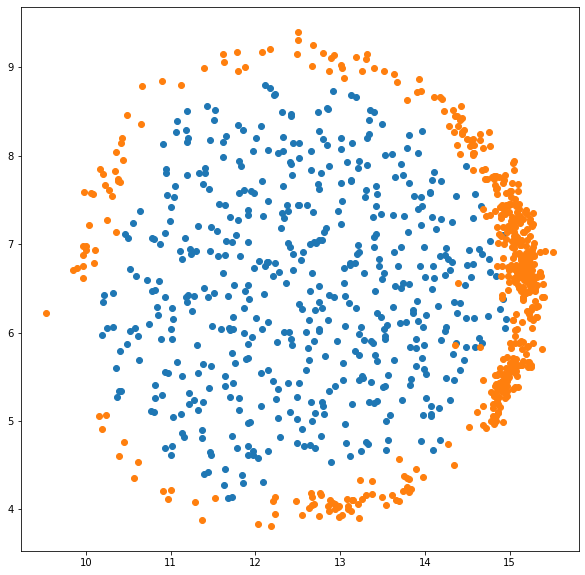

In [53]:
plt.figure(figsize=(10,10))
plt.scatter(embedding_ones[:,0], embedding_ones[:,1])
plt.scatter(embedding_zeros[:,0], embedding_zeros[:,1])

In [54]:
pca = PCA(n_components=2)
embedding_ones = pca.fit_transform(one_amps)
embedding_zeros = pca.transform(zero_amps)

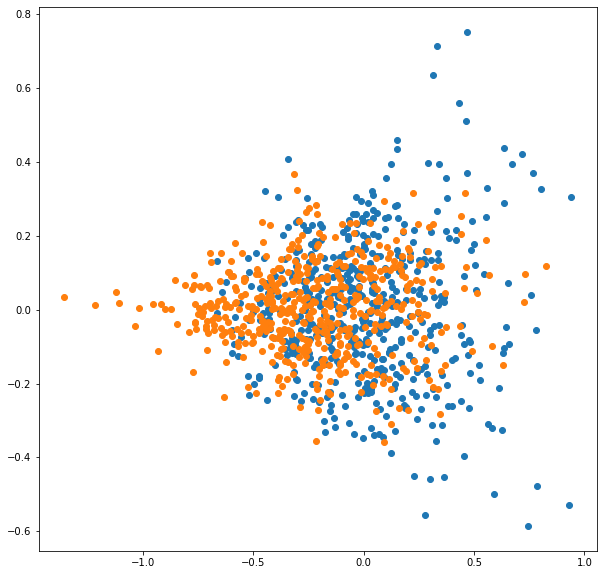

In [55]:
plt.figure(figsize=(10,10))
plt.scatter(embedding_ones[:,0], embedding_ones[:,1])
plt.scatter(embedding_zeros[:,0], embedding_zeros[:,1])

In [56]:
import itertools
from scipy.spatial import distance

In [57]:
pairs = [c for c in itertools.combinations(range(64), 2)]

In [58]:
len(pairs)

2016

In [92]:
data = []
l = 100
# for each value between 0 and 1
for i in np.linspace(0,1,l):
    x = []    
    for n in range(N):
        # for each input feature sample a sparse vector and set the input for the test feature to the specified value
        vs, _ = sample_vectors_equal(N, eps, 1, torch.tensor(fixed_embedder, requires_grad=False, device='cuda', dtype=torch.float))
        vs = vs.cpu().numpy()
#         print(vs.shape)
        vs[:,n] = i
        # embed the sample vector and store the embedding
        ins = np.squeeze(np.dot(vs, fixed_embedder.T))
#         print(ins.shape)
        x.append(ins)
#     print(np.array(x).shape)
    dists = []
#     print(x[p[0]].shape)
    # for every choose 2 pair of embedded vectors calculate the manhatten distance between them and store
    for p in pairs:
        dists.append(np.linalg.norm((x[p[0]] - x[p[1]]), ord=1))
    data.append(dists)

/tmp/ipykernel_243866/3842755685.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vs, _ = sample_vectors_equal(N, eps, 1, torch.tensor(fixed_embedder, requires_grad=False, device='cuda', dtype=torch.float))


In [93]:
print(np.array(data).shape)

(100, 2016)


In [94]:
# for each test feature value calculate the mean manhatten distance between every pair of vectors.
means = [np.mean(data[i]) for i in range(l)]
stds = [np.std(data[i]) for i in range(l)]

In [95]:
means

[14.432247,
 14.853649,
 14.369465,
 14.645547,
 14.754051,
 14.190418,
 14.285196,
 14.14791,
 14.629971,
 14.615109,
 14.789446,
 14.47207,
 14.123357,
 15.267601,
 14.434065,
 13.905603,
 14.957409,
 14.0856085,
 15.074455,
 14.710953,
 14.33037,
 14.5487,
 14.630574,
 15.170164,
 15.100099,
 14.074348,
 14.274365,
 14.65077,
 14.624018,
 14.943259,
 15.462464,
 14.192363,
 14.2113695,
 14.774195,
 14.771099,
 14.932022,
 14.542291,
 15.253677,
 15.079502,
 15.801023,
 14.941492,
 14.7959,
 15.181143,
 14.483639,
 15.103961,
 14.597452,
 15.820466,
 15.704913,
 15.234627,
 15.465319,
 15.507565,
 15.202387,
 15.543748,
 15.476127,
 15.278487,
 15.267534,
 15.710902,
 15.328208,
 15.096833,
 15.764926,
 15.314629,
 15.078457,
 15.742968,
 15.500922,
 15.897768,
 15.811244,
 15.215685,
 16.884407,
 15.9626875,
 14.99485,
 15.334279,
 15.756034,
 16.170591,
 16.030361,
 15.397035,
 16.098133,
 15.655281,
 16.866392,
 16.054272,
 16.633245,
 15.885471,
 16.206114,
 16.143032,
 16.252645

<ErrorbarContainer object of 3 artists>

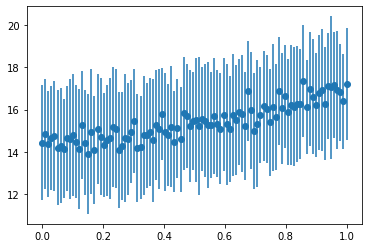

In [96]:
plt.errorbar(np.linspace(0,1,l), means, yerr=stds, fmt='o')

On average as the value of the test feature is increased the manhattan distance between every choose 2 pair of test embedded input vectors increases. This indicates that the "signature" of higher amplitude inputs are more distinct than lower amplitude inputs.

In [97]:
data = []
l = 100
# for each value between 0 and 1
for i in np.linspace(0,1,l):
    x = []    
    for n in range(N):
        # for each input feature sample a sparse vector and set the input for the test feature to the specified value
        vs, _ = sample_vectors_equal(N, eps, 1000, torch.tensor(fixed_embedder, requires_grad=False, device='cuda', dtype=torch.float))
        vs = vs.cpu().numpy()
#         print(vs.shape)
        vs[:,n] = i
        # embed the sample vector and store the embedding
        ins = np.squeeze(np.dot(vs, fixed_embedder.T))
#         print(ins.shape)
        x.append(ins)
#     print(np.array(x).shape)
    dists = []
#     print(x[p[0]].shape)
    # for every choose 2 pair of embedded vectors calculate the manhatten distance between them and store
    for p in pairs:
        dists.append(np.linalg.norm((x[p[0]] - x[p[1]]), ord=1, axis=1))
    data.append(dists)

/tmp/ipykernel_243866/3639921767.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vs, _ = sample_vectors_equal(N, eps, 1000, torch.tensor(fixed_embedder, requires_grad=False, device='cuda', dtype=torch.float))


In [98]:
print(np.array(data[0]).shape)
print(len(data[0]))

(2016, 1000)
2016


In [106]:
means = np.array([np.mean(data[i]) for i in range(l)])
stds = np.array([np.std(np.mean(np.array(data[i]), axis=1), axis=0) for i in range(l)])

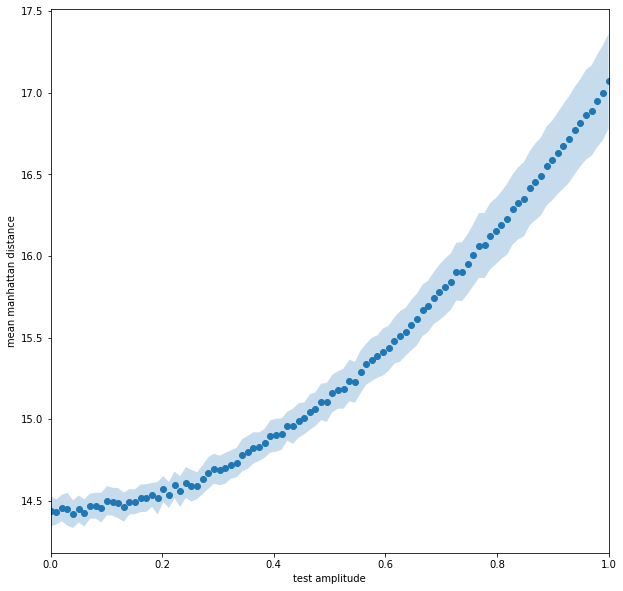

In [110]:
plt.figure(figsize=(10,10))
plt.plot(np.linspace(0,1,l), means,'o')
plt.fill_between(np.linspace(0,1,l), means-stds, means+stds, alpha=0.25)
# plt.ylim(0,20)
plt.xlim(0,1)
plt.xlabel('test amplitude')
plt.ylabel('mean manhattan distance')
plt.show()

In [111]:
import seaborn as sns

0.0


/tmp/ipykernel_5680/3464095624.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v, _ = sample_vectors_equal(N, eps, trials, torch.tensor(fixed_embedder, requires_grad=False, device='cuda', dtype=torch.float))


41.980000000000004
0.25
44.51
0.5
54.57
0.75
73.28999999999999
1.0
107.68


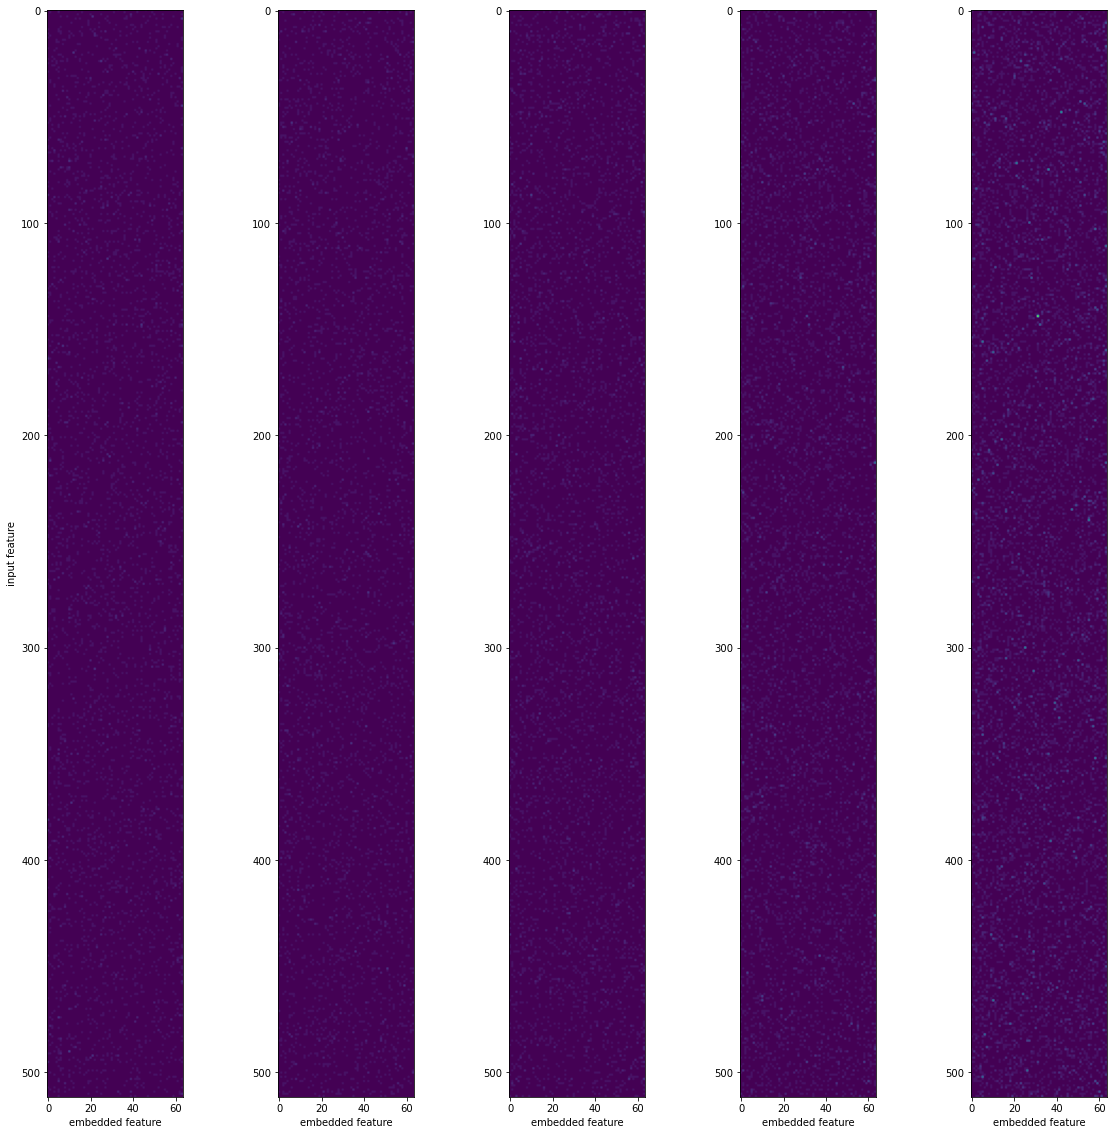

In [8]:
# improve this by checking the distribution of ins generated and set threshold for counting based on that
trials = 100
spacing = 5
pss = []
fig = plt.figure(figsize=(20,20))
plot_counter = 1
for k in np.linspace(0,1,spacing):
    print(k)
    ps = np.zeros((512, 64))
    ax = fig.add_subplot(1,spacing,plot_counter)
    for i in range(N):
        for j in range(m):
            v, _ = sample_vectors_equal(N, eps, trials, torch.tensor(fixed_embedder, requires_grad=False, device='cuda', dtype=torch.float))
            v = v.cpu().numpy()
            v[:,i] = k
            ins = np.squeeze(np.dot(v, fixed_embedder.T))
#             p = np.sum(np.array(np.abs(ins) > 0.75), axis=0)
            p = np.mean(np.array(np.abs(ins) > 0.75), axis=0)
#             p = np.mean(np.abs(ins), axis= 0)
#             print(p.shape)
            ps[i,j] = p[j]

    ax.imshow(ps, vmin=0., vmax=0.2)
#     ax.imshow(ps, cmap='gray')
    ax.set_xlabel('embedded feature')
    if plot_counter == 1:
        ax.set_ylabel('input feature')
    print(np.sum(ps))
#     print(np.mean(ps))
    plot_counter += 1
plt.show()

In [9]:
print(np.max(ps))

0.19
